## Stock Price Prediction using Support Vector Regression (SVR) and Random Forest (RF) Regression with Feature Engineering & Hyperparameter Tuning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from pandas_datareader import data as pdr
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Configure Yahoo Finance data source
# Download historical stock data
ticker = "GOOGL"
start_date = "2018-01-01"
end_date = "2023-10-31"

df = yf.download(ticker, start=start_date, end=end_date, progress=False)
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,52.651001,53.799000,52.651001,53.660500,53.660500,31766000
2018-01-03,53.696499,54.805000,53.671501,54.576000,54.576000,31318000
2018-01-04,54.854500,55.203999,54.713001,54.787998,54.787998,26052000
2018-01-05,55.172501,55.679001,55.090000,55.514500,55.514500,30250000
2018-01-08,55.549999,55.958000,55.500000,55.710499,55.710499,24644000
...,...,...,...,...,...,...
2023-10-24,137.830002,139.360001,137.419998,138.809998,138.809998,44814300
2023-10-25,128.160004,128.309998,125.070000,125.610001,125.610001,84366200
2023-10-26,123.269997,124.330002,121.269997,122.279999,122.279999,57061100


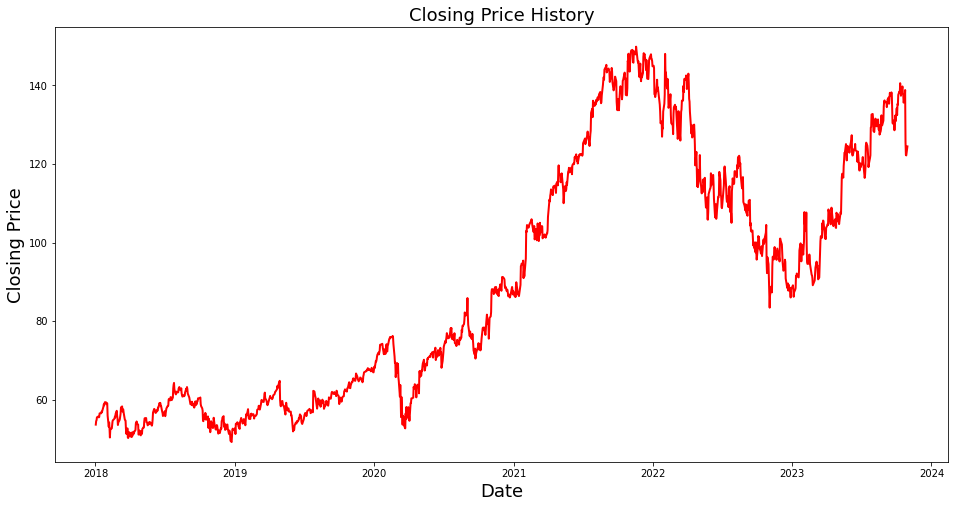

In [3]:
# Plot the closing price history
plt.figure(figsize=(16,8))
plt.title('Closing Price History', fontsize=18)
plt.plot(df['Close'], linewidth=2, color='red')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Closing Price', fontsize=18)
plt.show()

In [4]:
# Feature Engineering
df['Return'] = df['Close'].pct_change() # Simple daily return
df['Moving_Avg_5'] = df['Close'].rolling(window=5).mean() # 5-day moving average
df['Moving_Avg_10'] = df['Close'].rolling(window=10).mean() # 10-day moving average
df['Moving_STD_10'] = df['Close'].rolling(window=10).std() # 10-day moving standard deviation

# Replace NA values with 0
df.fillna(0, inplace=True)

df.head(30)

,Open,High,Low,Close,Adj Close,Volume,Return,Moving_Avg_5,Moving_Avg_10,Moving_STD_10
Date,,,,,,,,,,
2018-01-02,52.651001,53.799000,52.651001,53.660500,53.660500,31766000,0.000000,0.000000,0.000000,0.000000
2018-01-03,53.696499,54.805000,53.671501,54.576000,54.576000,31318000,0.017061,0.000000,0.000000,0.000000
2018-01-04,54.854500,55.203999,54.713001,54.787998,54.787998,26052000,0.003884,0.000000,0.000000,0.000000
2018-01-05,55.172501,55.679001,55.090000,55.514500,55.514500,30250000,0.013260,0.000000,0.000000,0.000000
2018-01-08,55.549999,55.958000,55.500000,55.710499,55.710499,24644000,0.003531,54.849899,0.000000,0.000000
2018-01-09,55.922001,55.922001,55.410000,55.639500,55.639500,26808000,-0.001274,55.245699,0.000000,0.000000
2018-01-10,55.349998,55.639000,55.199001,55.507000,55.507000,20734000,-0.002381,55.431899,0.000000,0.000000
2018-01-11,55.615501,55.742500,55.324001,55.602501,55.602501,22424000,0.001721,55.594800,0.000000,0.000000
2018-01-12,55.505001,56.564999,55.400501,56.532501,56.532501,38586000,0.016726,55.798400,0.000000,0.000000


In [5]:
# Removing first 9 rows since they contain 0 values
df1 = df[9:]

df1.head()

,Open,High,Low,Close,Adj Close,Volume,Return,Moving_Avg_5,Moving_Avg_10,Moving_STD_10
Date,,,,,,,,,,
2018-01-16,57.015499,57.444000,56.3330,56.535000,56.535000,36462000,0.000044,55.963300,55.40660,0.873630
2018-01-17,56.818001,56.966000,56.1745,56.955002,56.955002,27830000,0.007429,56.226401,55.73605,0.755158
2018-01-18,56.967499,57.029499,56.2230,56.798500,56.798500,27498000,-0.002748,56.484701,55.95830,0.700913
2018-01-19,56.901501,57.188999,56.6250,57.174999,57.174999,30552000,0.006629,56.799200,56.19700,0.663533
2018-01-22,57.191002,58.344002,57.0910,58.208000,58.208000,29550000,0.018067,57.134300,56.46635,0.870204


In [6]:
df1.dropna(inplace=True)

In [7]:
# Define the features and the target variable
features = ['Open', 'High', 'Low', 'Return', 'Moving_Avg_5', 'Moving_Avg_10', 'Moving_STD_10']

X = df1[features]
y = df1['Close']

# Feature Scaling
feature_scaler = MinMaxScaler()
X_scaled = feature_scaler.fit_transform(X)

target_scaler = MinMaxScaler()
y_scaled = target_scaler.fit_transform(y.values.reshape(-1,1))

In [8]:
# Split the data into training and testing sets using 80-20 split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, shuffle=False, random_state=42)

In [9]:
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (1166, 7)
y_train shape:  (1166, 1)
X_test shape:  (292, 7)
y_test shape:  (292, 1)


In [10]:
# RF without hyperparameter tuning
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)

# SVR without hyperparameter tuning
svr = SVR()
svr.fit(X_train, y_train)
pred_svr = svr.predict(X_test)

In [11]:
# Denormalize the predictions
pred_rf_inv = target_scaler.inverse_transform(pred_rf.reshape(-1,1))
pred_svr_inv = target_scaler.inverse_transform(pred_svr.reshape(-1,1))
y_test_inv = target_scaler.inverse_transform(y_test.reshape(-1,1))

In [12]:
# Calculate the evaluation metrics for RF
mse_rf = mean_squared_error(y_test_inv, pred_rf_inv)
rmse_rf = np.sqrt(mse_rf)
mae_rf = mean_absolute_error(y_test_inv, pred_rf_inv)
r2_rf = r2_score(y_test_inv, pred_rf_inv)

print('RF Model Evaluation Metrics')
print('===========================')
print('MSE: {:.4f}'.format(mse_rf))
print('RMSE: {:.4f}'.format(rmse_rf))
print('MAE: {:.4f}'.format(mae_rf))
print('R2: {:.4f}'.format(r2_rf))

RF Model Evaluation Metrics
MSE: 1.6191
RMSE: 1.2725
MAE: 0.9528
R2: 0.9938


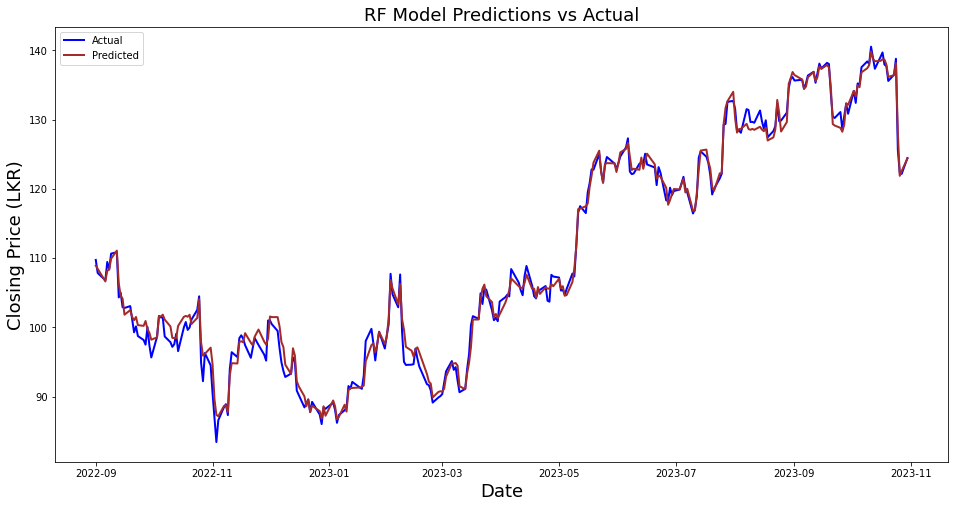

In [13]:
# Plot the predicted values vs actual values
plt.figure(figsize=(16,8))
plt.title('RF Model Predictions vs Actual', fontsize=18)
plt.plot(df1.index[-len(y_test):], y_test_inv, label='Actual', color='blue', linewidth=2)
plt.plot(df1.index[-len(y_test):], pred_rf_inv, label='Predicted', color='brown', linewidth=2)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Closing Price (LKR)', fontsize=18)
plt.legend()
plt.show()

In [14]:
# Calculate the Evaluation Metrics for SVR
mse_svr = mean_squared_error(y_test_inv, pred_svr_inv)
rmse_svr = np.sqrt(mse_svr)
mae_svr = mean_absolute_error(y_test_inv, pred_svr_inv)
r2_svr = r2_score(y_test_inv, pred_svr_inv)

print('SVR Model Evaluation Metrics')
print('============================')
print('MSE: {:.4f}'.format(mse_svr))
print('RMSE: {:.4f}'.format(rmse_svr))
print('MAE: {:.4f}'.format(mae_svr))
print('R2: {:.4f}'.format(r2_svr))

SVR Model Evaluation Metrics
MSE: 4.5108
RMSE: 2.1239
MAE: 1.7096
R2: 0.9827


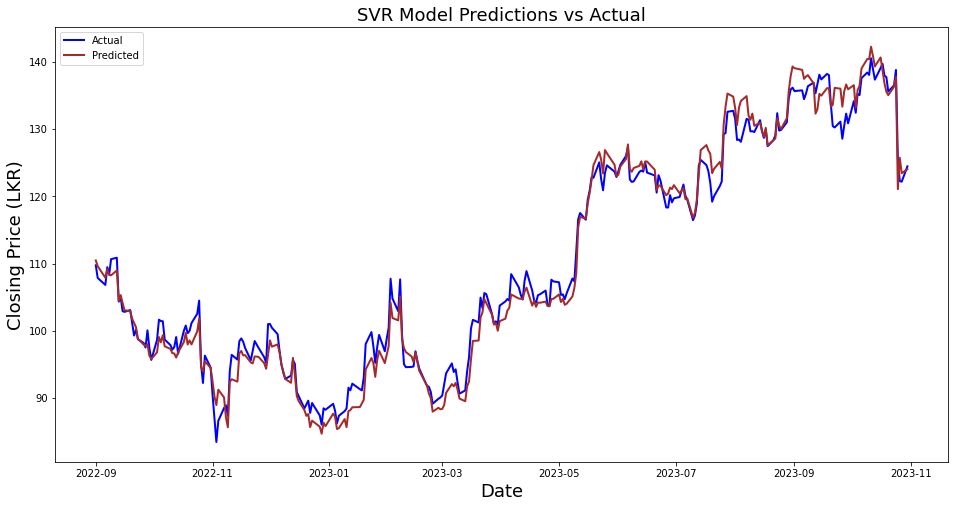

In [15]:
# Plot the predicted values vs the actual values
plt.figure(figsize=(16,8))
plt.title('SVR Model Predictions vs Actual', fontsize=18)
plt.plot(df1.index[-len(y_test):], y_test_inv, label='Actual', color='blue', linewidth=2)
plt.plot(df1.index[-len(y_test):], pred_svr_inv, label='Predicted', color='brown', linewidth=2)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Closing Price (LKR)', fontsize=18)
plt.legend()
plt.show()

In [16]:
# Create a stacked model with RF and SVR
stacked_pred = np.column_stack((pred_rf, pred_svr))

# Train a final regressor based on the stacked predictions
final_regressor = LinearRegression().fit(stacked_pred, y_test)

# Predict on the test data
final_pred = final_regressor.predict(stacked_pred)

# Inverse transform the predictions
final_pred_inv = target_scaler.inverse_transform(final_pred.reshape(-1,1))

# Calculate the Evaluation Metrics for Stacked model
final_mse = mean_squared_error(y_test_inv, final_pred_inv)
final_rmse = np.sqrt(mean_squared_error(y_test_inv, final_pred_inv))
final_mae = mean_absolute_error(y_test_inv, final_pred_inv)
final_r2 = r2_score(y_test_inv, final_pred_inv)

print("RF-SVR Stacked Model Evaluation Metrics")
print("=======================================")
print("MSE: {:.4f}".format(final_mse))
print("RMSE: {:.4f}".format(final_rmse))
print("MAE: {:.4f}".format(final_mae))
print("R2: {:.4f}".format(final_r2))

RF-SVR Stacked Model Evaluation Metrics
MSE: 1.3563
RMSE: 1.1646
MAE: 0.9040
R2: 0.9948


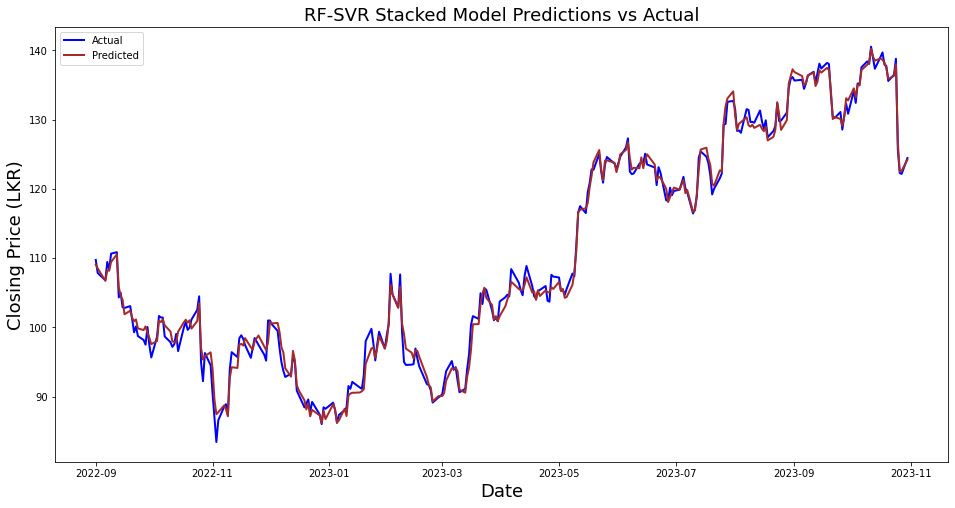

In [17]:
# Plot the predictions vs actual
plt.figure(figsize=(16,8))
plt.title('RF-SVR Stacked Model Predictions vs Actual', fontsize=18)
plt.plot(df1.index[-len(y_test):], y_test_inv, linewidth=2, color='blue', label='Actual')
plt.plot(df1.index[-len(y_test):], final_pred_inv, linewidth=2, color='brown', label='Predicted')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Closing Price (LKR)', fontsize=18)
plt.legend()
plt.show()

In [18]:
# Build a dataframe with actual and predicted prices
df_pred = pd.DataFrame({'Date': df1.index[-len(y_test):],'Actual': y_test_inv.flatten(), 'RF': pred_rf_inv.flatten(), 'SVR': pred_svr_inv.flatten(), 'RF-SVR': final_pred_inv.flatten()})
df_pred.head(20)

,Date,Actual,RF,SVR,RF-SVR
0,2022-09-01,109.739998,108.913506,110.458194,109.058645
1,2022-09-02,107.849998,108.451956,109.598923,108.519568
2,2022-09-06,106.809998,106.632680,107.886773,106.715925
3,2022-09-07,109.449997,108.176216,109.148575,108.209595
4,2022-09-08,108.379997,108.351306,108.290732,108.187049
5,2022-09-09,110.650002,109.914200,108.250477,109.446691
6,2022-09-12,110.860001,111.087990,108.963163,110.535215
7,2022-09-13,104.320000,106.387615,104.443615,105.856826
8,2022-09-14,105.000000,104.557876,105.293996,104.536173
9,2022-09-15,102.910004,104.165365,104.118818,103.992492


In [19]:
# Take the last day of data for predictions
last_features = X_scaled[-1:]

predicted_prices_rf = []

last_features_rf = last_features.copy()

for _ in range(2):
    # Predicting the next day stock price using the last feature data
    predicted_price_rf = rf.predict(last_features_rf)
    
    # Reshape the predicted price for inverse scaling
    predicted_price_reshaped_rf = predicted_price_rf.reshape(-1, 1)
    
    # Saving the predicted price after inverse transformation
    inverse_transformed_price_rf = target_scaler.inverse_transform(predicted_price_reshaped_rf)[0][0]
    predicted_prices_rf.append(inverse_transformed_price_rf)

    # Computing new features based on the predicted price
    # Here we reuse the logic for LSTM for simplicity. Depending on the scenario, the exact methodology might change.
    new_features_rf = np.array([
        last_features_rf[0, 1], 
        last_features_rf[0, 2], 
        predicted_price_reshaped_rf[0, 0], 
        (predicted_price_reshaped_rf[0, 0] - last_features_rf[0, 3]) / last_features_rf[0, 3],
        np.mean(np.append(last_features_rf[0, 4:6], predicted_price_reshaped_rf[0, 0])),
        np.mean(np.append(last_features_rf[0, 5:], predicted_price_reshaped_rf[0, 0])),
        np.std(np.append(last_features_rf[0, 6:], predicted_price_reshaped_rf[0, 0]))
    ], dtype=np.float32).reshape(1, 7)

    last_features_rf = new_features_rf

print("Predicted Closing Prices for the Next 2 Days (RF Model):")
for i, price in enumerate(predicted_prices_rf):
    print(f"Day {i+1}:" "{:.3f}".format(price))

Predicted Closing Prices for the Next 2 Days (RF Model):
Day 1:124.387
Day 2:123.997


In [20]:
last_features = X_scaled[-1:]

# Predict using the svr model
predicted_prices_svr = []

last_features_svr = last_features.copy()

for _ in range(2):
    # Predicting the next day stock price using the last feature data
    predicted_price_svr = svr.predict(last_features_svr)
    
    # Reshape the predicted price for inverse scaling
    predicted_price_reshaped_svr = predicted_price_svr.reshape(-1, 1)
    
    # Saving the predicted price after inverse transformation
    inverse_transformed_price_svr = target_scaler.inverse_transform(predicted_price_reshaped_svr)[0][0]
    predicted_prices_svr.append(inverse_transformed_price_svr)

    # Computing new features based on the predicted price
    # Here we reuse the logic for LSTM for simplicity. Depending on the scenario, the exact methodology might change.
    new_features_svr = np.array([
        last_features_svr[0, 1], 
        last_features_svr[0, 2], 
        predicted_price_reshaped_svr[0, 0], 
        (predicted_price_reshaped_svr[0, 0] - last_features_svr[0, 3]) / last_features_svr[0, 3],
        np.mean(np.append(last_features_svr[0, 4:6], predicted_price_reshaped_svr[0, 0])),
        np.mean(np.append(last_features_svr[0, 5:], predicted_price_reshaped_svr[0, 0])),
        np.std(np.append(last_features_svr[0, 6:], predicted_price_reshaped_svr[0, 0]))
    ], dtype=np.float32).reshape(1, 7)

    last_features_svr = new_features_svr

print("\nPredicted Closing Prices for the Next 2 Days (SVR Model):")
for i, price in enumerate(predicted_prices_svr):
    print(f"Day {i+1}:" "{:.3f}".format(price))


Predicted Closing Prices for the Next 2 Days (SVR Model):
Day 1:124.038
Day 2:118.282


In [21]:
last_features = X_scaled[-1:]

# Predict using the Stacked RF-SVR model
predicted_prices_stacked = []

last_features_stacked = last_features.copy()

for _ in range(2):
    
    # Predict using RF & SVR models
    rf_pred_for_stacking = rf.predict(last_features_stacked)
    svr_pred_for_stacking = svr.predict(last_features_stacked)

    # Stacking RF and SVR predictions
    stacked_predictions = np.column_stack((rf_pred_for_stacking, svr_pred_for_stacking))
    
    # Predict using the final regressor
    predicted_stacked = final_regressor.predict(stacked_predictions)

    # Reshape the predicted price for inverse scaling
    predicted_price_reshaped_stacked = predicted_stacked.reshape(-1, 1)

    # Saving the predicted price after inverse transformation
    inverse_transformed_price_stacked = target_scaler.inverse_transform(predicted_price_reshaped_stacked)[0][0]
    predicted_prices_stacked.append(inverse_transformed_price_stacked)

    # Computing new features based on the predicted price
    new_features_stacked = np.array([
        last_features_stacked[0, 1], 
        last_features_stacked[0, 2], 
        predicted_price_reshaped_stacked[0, 0], 
        (predicted_price_reshaped_stacked[0, 0] - last_features_stacked[0, 3]) / last_features_stacked[0, 3],
        np.mean(np.append(last_features_stacked[0, 4:6], predicted_price_reshaped_stacked[0, 0])),
        np.mean(np.append(last_features_stacked[0, 5:], predicted_price_reshaped_stacked[0, 0])),
        np.std(np.append(last_features_stacked[0, 6:], predicted_price_reshaped_stacked[0, 0]))
    ], dtype=np.float32).reshape(1, 7)

    last_features_stacked = new_features_stacked

print("Predicted Closing Prices for the Next 2 Days (RF-SVR Stacked Model):")
for i, price in enumerate(predicted_prices_stacked):
    print(f"Day {i+1}:" "{:.3f}".format(price))

Predicted Closing Prices for the Next 2 Days (RF-SVR Stacked Model):
Day 1:124.211
Day 2:122.811


In [22]:
# Hyperparameter Tuning: Random Forest Regressor
parameters_rf = {'n_estimators': [100, 200, 300],
                'max_depth': [None, 5, 10, 15, 20],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4],
                'max_features': ['auto', 'sqrt', 'log2'],
                'bootstrap': [True, False]}

rf = RandomForestRegressor()
grid_rf = GridSearchCV(estimator=rf, param_grid=parameters_rf, cv=5, verbose=1, n_jobs=-1)
grid_rf.fit(X_train, y_train)

# Print the best parameters
print("Best parameters: ", grid_rf.best_params_)
print("Best score: ", grid_rf.best_score_)
print("Best estimator: ", grid_rf.best_estimator_)
print("Best index: ", grid_rf.best_index_)
print("Scorer function: ", grid_rf.scorer_)

# Using the best estimator for RF from the grid search
best_rf_model = grid_rf.best_estimator_

# Predicting the test set results
pred_best_rf = best_rf_model.predict(X_test)

# Inverse transform the predicted values
pred_best_rf_inv = target_scaler.inverse_transform(pred_best_rf.reshape(-1,1))

Fitting 5 folds for each of 810 candidates, totalling 4050 fits


Best parameters:  {'bootstrap': True, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best score:  0.9626906978142629
Best estimator:  RandomForestRegressor(max_features='auto')
Best index:  0
Scorer function:  <function _passthrough_scorer at 0x000001B3FFEEC820>


In [23]:
# Calculate the Evaluation Metrics for RF model with hyperparameter tuning
rf_tuned_mse = mean_squared_error(y_test_inv, pred_best_rf_inv)
rf_tuned_rmse = np.sqrt(mean_squared_error(y_test_inv, pred_best_rf_inv))
rf_tuned_mae = mean_absolute_error(y_test_inv, pred_best_rf_inv)
rf_tuned_r2 = r2_score(y_test_inv, pred_best_rf_inv)

print("Tuned Random Forest Model Evaluation Metrics")
print("============================================")
print("MSE: {:.4f}".format(rf_tuned_mse))
print("RMSE: {:.4f}".format(rf_tuned_rmse))
print("MAE: {:.4f}".format(rf_tuned_mae))
print("R2: {:.4f}".format(rf_tuned_r2))

Tuned Random Forest Model Evaluation Metrics
MSE: 1.4589
RMSE: 1.2078
MAE: 0.9221
R2: 0.9944


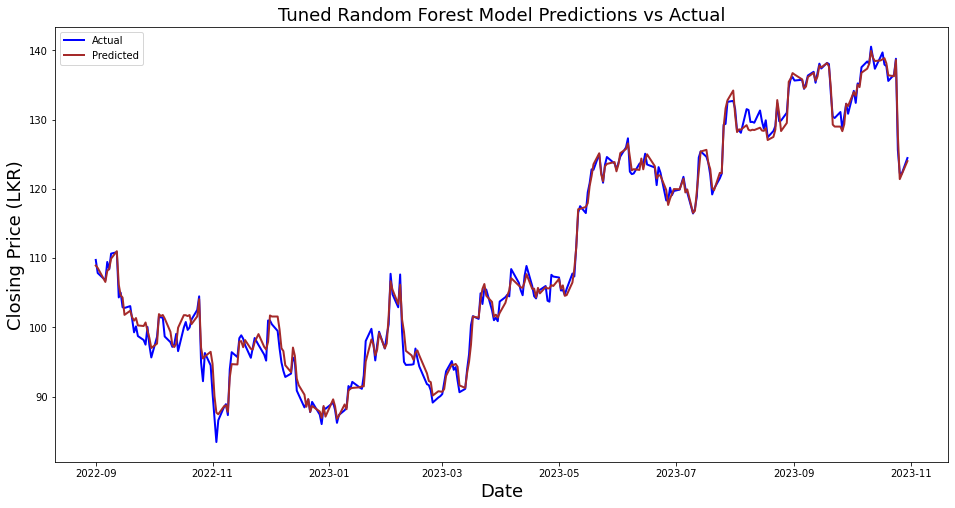

In [24]:
# Plot the predicted vs Actual values for Tuned Random Forest model
plt.figure(figsize=(16,8))
plt.title('Tuned Random Forest Model Predictions vs Actual', fontsize=18)
plt.plot(df1.index[-len(y_test):], y_test_inv, linewidth=2, color='blue', label='Actual')
plt.plot(df1.index[-len(y_test):], pred_best_rf_inv, linewidth=2, color='brown', label='Predicted')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Closing Price (LKR)', fontsize=18)
plt.legend()
plt.show()

In [25]:
# Hyperparameter Tuning: SVR
parameters_svr = {'kernel': ['linear', 'rbf'], 'C': [0.1, 1, 10], 'gamma': [0.1, 1], 'epsilon': [0.1, 0.2, 0.5, 1]}

svr = SVR()
svr_grid = GridSearchCV(svr, parameters_svr, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
svr_grid.fit(X_train, y_train)

print("Best Parameters for SVR: ", svr_grid.best_params_)
print("Best Score for SVR: ", svr_grid.best_score_)
print("Best Estimator for SVR: ", svr_grid.best_estimator_)
print("Best Index for SVR: ", svr_grid.best_index_)
print("Scorer for SVR: ", svr_grid.scorer_)

# Using the best estimator for SVR from the grid search
svr_best = svr_grid.best_estimator_

# Predicting the test set results
pred_best_svr = svr_best.predict(X_test)

# Inverse transforming the predicted values
pred_best_svr_inv = target_scaler.inverse_transform(pred_best_svr.reshape(-1, 1))

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Parameters for SVR:  {'C': 1, 'epsilon': 0.1, 'gamma': 1, 'kernel': 'rbf'}
Best Score for SVR:  -0.002160969531255808
Best Estimator for SVR:  SVR(C=1, gamma=1)
Best Index for SVR:  19
Scorer for SVR:  make_scorer(mean_squared_error, greater_is_better=False)


In [26]:
# Calculate the evaluation metrics for SVR model with Hyperparameter tuning
svr_tuned_mse = mean_squared_error(y_test_inv, pred_best_svr_inv)
svr_tuned_rmse = np.sqrt(svr_tuned_mse)
svr_tuned_mae = mean_absolute_error(y_test_inv, pred_best_svr_inv)
svr_tuned_r2 = r2_score(y_test_inv, pred_best_svr_inv)

print("Tuned SVR Model Evaluation Metrics")
print("==================================")
print("MSE: {:.4f}".format(svr_tuned_mse))
print("RMSE: {:.4f}".format(svr_tuned_rmse))
print("MAE: {:.4f}".format(svr_tuned_mae))
print("R2: {:.4f}".format(svr_tuned_r2))

Tuned SVR Model Evaluation Metrics
MSE: 7.3099
RMSE: 2.7037
MAE: 2.2592
R2: 0.9720


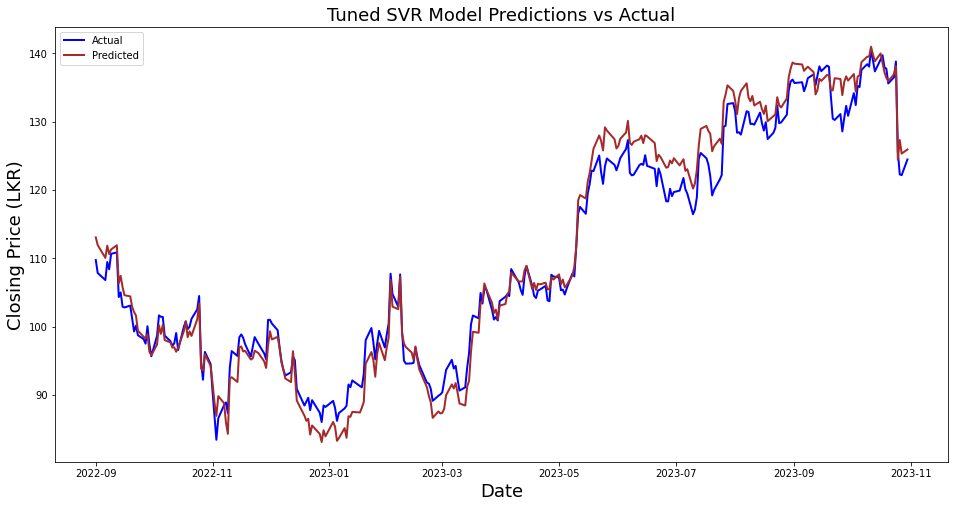

In [27]:
# Plot the predicted vs Actual values for Tuned Random Forest model
plt.figure(figsize=(16,8))
plt.title('Tuned SVR Model Predictions vs Actual', fontsize=18)
plt.plot(df1.index[-len(y_test):], y_test_inv, linewidth=2, color='blue', label='Actual')
plt.plot(df1.index[-len(y_test):], pred_best_svr_inv, linewidth=2, color='brown', label='Predicted')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Closing Price (LKR)', fontsize=18)
plt.legend()
plt.show()

In [28]:
from sklearn.linear_model import LinearRegression

# Create a stacked model using np.column_stack
stacked_tune_pred = np.column_stack((pred_best_rf, pred_best_svr))

# Train a final regressor based on the stacked predictions
final_tuned_regressor = LinearRegression().fit(stacked_tune_pred, y_test)

# Predict on the test data
final_tuned_pred = final_tuned_regressor.predict(stacked_tune_pred)

# Inverse transform the predictions
final_tuned_pred_inv = target_scaler.inverse_transform(final_tuned_pred.reshape(-1,1))

In [29]:
# Calculate the evaluation metrics for the stacked ensemble model with hyperparameter tuning
final_tuned_mse = mean_squared_error(y_test_inv, final_tuned_pred_inv)
final_tuned_rmse = np.sqrt(final_tuned_mse)
final_tuned_mae = mean_absolute_error(y_test_inv, final_tuned_pred_inv)
final_tuned_r2 = r2_score(y_test_inv, final_tuned_pred_inv)

print('Tuned RF-SVR Stacked Model Evaluation Metrics')
print("=============================================")
print('MSE: {:.4f}'.format(final_tuned_mse))
print('RMSE: {:.4f}'.format(final_tuned_rmse))
print('MAE: {:.4f}'.format(final_tuned_mae))
print('R2: {:.4f}'.format(final_tuned_r2))

Tuned RF-SVR Stacked Model Evaluation Metrics
MSE: 1.2330
RMSE: 1.1104
MAE: 0.8670
R2: 0.9953


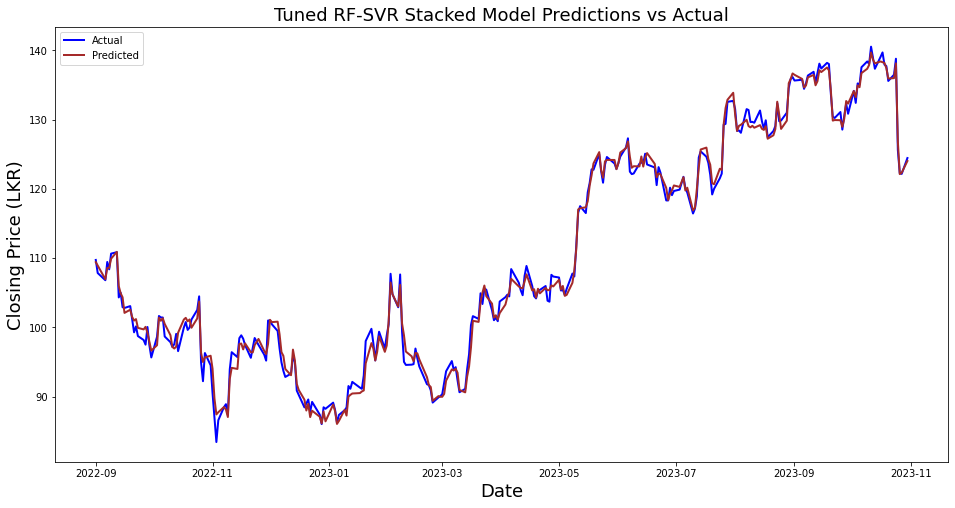

In [30]:
# Plot the predicted vs Actual values for Tuned Random Forest model
plt.figure(figsize=(16,8))
plt.title('Tuned RF-SVR Stacked Model Predictions vs Actual', fontsize=18)
plt.plot(df1.index[-len(y_test):], y_test_inv, linewidth=2, color='blue', label='Actual')
plt.plot(df1.index[-len(y_test):], final_tuned_pred_inv, linewidth=2, color='brown', label='Predicted')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Closing Price (LKR)', fontsize=18)
plt.legend()
plt.show()

In [31]:
# Build a dataframe with actual and predicted prices
df_pred_1 = pd.DataFrame({'Date': df1.index[-len(y_test):],'Actual': y_test_inv.flatten(), 'RF-Tuned': pred_best_rf_inv.flatten(), 'SVR-Tuned': pred_best_svr_inv.flatten(), 'Tuned RF-SVR': final_tuned_pred_inv.flatten()})
df_pred_1.tail(20)

,Date,Actual,RF-Tuned,SVR-Tuned,Tuned RF-SVR
272,2023-10-03,132.429993,133.449346,134.404998,133.245054
273,2023-10-04,135.240005,135.068952,136.595297,134.956395
274,2023-10-05,135.070007,134.711513,136.788777,134.697733
275,2023-10-06,137.580002,136.784313,138.721514,136.734875
276,2023-10-09,138.419998,137.377074,139.511125,137.359097
277,2023-10-10,138.059998,138.044374,139.528211,137.908511
278,2023-10-11,140.550003,139.939287,140.977515,139.714985
279,2023-10-12,138.970001,138.933746,139.817446,138.687622
280,2023-10-13,137.360001,138.476950,138.847797,138.143075
281,2023-10-16,139.100006,138.566860,139.980253,138.415830


In [32]:
# Predict using the best RF model
predicted_prices_best_rf = []

last_features_best_rf = last_features.copy()

for _ in range(2):
    # Predicting the next day stock price using the last feature data
    predicted_price_best_rf = best_rf_model.predict(last_features_best_rf)
    
    # Reshape the predicted price for inverse scaling
    predicted_price_reshaped_best_rf = predicted_price_best_rf.reshape(-1, 1)

    # Saving the predicted price after inverse transformation
    inverse_transformed_price_best_rf = target_scaler.inverse_transform(predicted_price_reshaped_best_rf)[0][0]
    predicted_prices_best_rf.append(inverse_transformed_price_best_rf)

    # Computing new features based on the predicted price
    new_features_best_rf = np.array([
        last_features_best_rf[0, 1], 
        last_features_best_rf[0, 2], 
        predicted_price_reshaped_best_rf[0, 0], 
        (predicted_price_reshaped_best_rf[0, 0] - last_features_best_rf[0, 3]) / last_features_best_rf[0, 3],
        np.mean(np.append(last_features_best_rf[0, 4:6], predicted_price_reshaped_best_rf[0, 0])),
        np.mean(np.append(last_features_best_rf[0, 5:], predicted_price_reshaped_best_rf[0, 0])),
        np.std(np.append(last_features_best_rf[0, 6:], predicted_price_reshaped_best_rf[0, 0]))
    ], dtype=np.float32).reshape(1, 7)

    last_features_best_rf = new_features_best_rf

print("Predicted Closing Prices for the Next 2 Days (Best RF Model):")
for i, price in enumerate(predicted_prices_best_rf):
    print(f"Day {i+1}:" "{:.3f}".format(price))

Predicted Closing Prices for the Next 2 Days (Best RF Model):
Day 1:124.024
Day 2:123.874


In [33]:
last_features = X_scaled[-1:]

# Predict using the best SVR model
predicted_prices_best_svr = []

last_features_best_svr = last_features.copy()

for _ in range(2):
    # Predicting the next day stock price using the last feature data
    predicted_price_best_svr = svr_best.predict(last_features_best_svr)

    # Reshape the predicted price for inverse scaling
    predicted_price_reshaped_best_svr = predicted_price_best_svr.reshape(-1, 1)

    # Saving the predicted price after inverse transformation
    inverse_transformed_price_best_svr = target_scaler.inverse_transform(predicted_price_reshaped_best_svr)[0][0]
    predicted_prices_best_svr.append(inverse_transformed_price_best_svr)

    # Computing new features based on the predicted price
    new_features_best_svr = np.array([
        last_features_best_svr[0, 1], 
        last_features_best_svr[0, 2], 
        predicted_price_reshaped_best_svr[0, 0], 
        (predicted_price_reshaped_best_svr[0, 0] - last_features_best_svr[0, 3]) / last_features_best_svr[0, 3],
        np.mean(np.append(last_features_best_svr[0, 4:6], predicted_price_reshaped_best_svr[0, 0])),
        np.mean(np.append(last_features_best_svr[0, 5:], predicted_price_reshaped_best_svr[0, 0])),
        np.std(np.append(last_features_best_svr[0, 6:], predicted_price_reshaped_best_svr[0, 0]))
    ], dtype=np.float32).reshape(1, 7)

    last_features_best_svr = new_features_best_svr

print("Predicted Closing Prices for the Next 2 Days (Best SVR Model):")
for i, price in enumerate(predicted_prices_best_svr):
    print(f"Day {i+1}:" "{:.3f}".format(price))

Predicted Closing Prices for the Next 2 Days (Best SVR Model):
Day 1:125.925
Day 2:123.521


In [34]:
last_features = X_scaled[-1:]

# Predict using the best Stacked model
predicted_prices_best_stacked = []

last_features_best_stacked = last_features.copy()

for _ in range(2):
    
    # Predict using RF & SVR models
    rf_pred_for_stacking = best_rf_model.predict(last_features_best_stacked)
    svr_pred_for_stacking = svr_best.predict(last_features_best_stacked)

    # Stacking RF and SVR predictions
    stacked_predictions = np.column_stack((rf_pred_for_stacking, svr_pred_for_stacking))
    
    # Predict using the final regressor
    predicted_stacked = final_tuned_regressor.predict(stacked_predictions)

    # Reshape the predicted price for inverse scaling
    predicted_price_reshaped_best_stacked = predicted_stacked.reshape(-1, 1)

    # Saving the predicted price after inverse transformation
    inverse_transformed_price_best_stacked = target_scaler.inverse_transform(predicted_price_reshaped_best_stacked)[0][0]
    predicted_prices_best_stacked.append(inverse_transformed_price_best_stacked)

    # Computing new features based on the predicted price
    new_features_best_stacked = np.array([
        last_features_best_stacked[0, 1], 
        last_features_best_stacked[0, 2], 
        predicted_price_reshaped_best_stacked[0, 0], 
        (predicted_price_reshaped_best_stacked[0, 0] - last_features_best_stacked[0, 3]) / last_features_best_stacked[0, 3],
        np.mean(np.append(last_features_best_stacked[0, 4:6], predicted_price_reshaped_best_stacked[0, 0])),
        np.mean(np.append(last_features_best_stacked[0, 5:], predicted_price_reshaped_best_stacked[0, 0])),
        np.std(np.append(last_features_best_stacked[0, 6:], predicted_price_reshaped_best_stacked[0, 0]))
    ], dtype=np.float32).reshape(1, 7)

    last_features_best_stacked = new_features_best_stacked

print("Predicted Closing Prices for the Next 2 Days (Best Stacked RF-SVR Model):")
for i, price in enumerate(predicted_prices_best_stacked):
    print(f"Day {i+1}:" "{:.3f}".format(price))

Predicted Closing Prices for the Next 2 Days (Best Stacked RF-SVR Model):
Day 1:124.036
Day 2:123.310
